# Assignment 2: Extracting Topics from the Documents

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt

In [3]:
# Download necessary NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\abelj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abelj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abelj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Task 1: Data Exploration

### 1. Load the text_docs dataset

In [6]:
text_docs_df = pd.read_csv("text_docs.csv")
text_docs_df.head(3)

,document_id,text
0,1,The stock market has been experiencing volatil...
1,2,"The economy is growing, and businesses are opt..."
2,3,Climate change is a critical issue that needs ...


### 2. Print no. of rows and unique documents

In [8]:
print(f"Number of rows: {text_docs_df.shape[0]}")

print(f"Number of unique documents: {text_docs_df["document_id"].nunique()}")

Number of rows: 10
Number of unique documents: 10


- All rows have unique documents. Therefore, number of rows = number of unique documents.

### 3. Identify required preprocessing steps

#### a. Lowercase the text

In [12]:
text_docs_df['processed_text'] = text_docs_df['text'].apply(lambda x: x.lower())

#### b. Remove punctuations and special characters

In [14]:
text_docs_df['processed_text'] = text_docs_df['processed_text'].str.replace(r'[^\w\s]', '', regex=True)

#### c. Tokenize the text

In [16]:
text_docs_df['processed_text'] = text_docs_df['processed_text'].apply(
    lambda x: word_tokenize(x)
)

#### d. Remove stop words

In [18]:
stop_words = set(stopwords.words('english'))

text_docs_df['processed_text'] = text_docs_df['processed_text'].apply(
    lambda x: [word for word in x if word not in stop_words]
)

#### e. Lemmatize the tokens

In [20]:
lemmatizer = WordNetLemmatizer()

text_docs_df['processed_text'] = text_docs_df['processed_text'].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in x]
)

- Decided to lemmatize in order to get complete words

#### f. Make tokens to list form to create dictionary and bag of words

In [23]:
preprocessed_tokens = text_docs_df['processed_text'].apply(
    lambda x: [token for token in x]
).tolist()

## Task 2: Generate Topics Using LDA

### 1. Create document-term matrix using bag of words representation

In [26]:
id2word = Dictionary(preprocessed_tokens)  # Gensim's Dictionary object
corpus = [id2word.doc2bow(tokens) for tokens in preprocessed_tokens]  # Document-term matrix in BoW format

### 2. Apply LDA to extract topics

#### Finding optimal number of topics

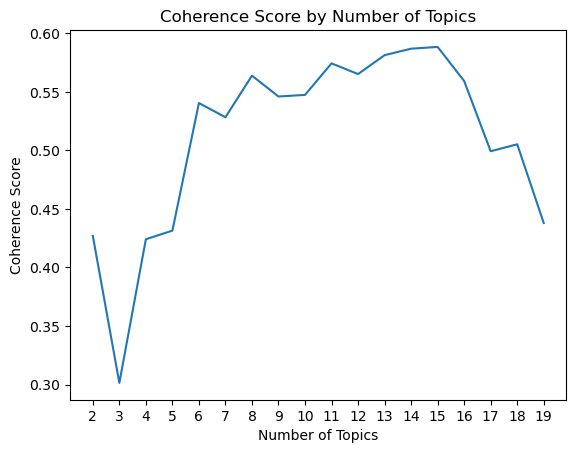

In [29]:
# Find the optimal number of topics using coherence scores
def compute_coherence_values(corpus, dictionary, texts, start, limit, step):
    coherence_values = []
    models = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        models.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return models, coherence_values

start, limit, step = 2, 20, 1  # Test topics from 2 to 20
models, coherence_values = compute_coherence_values(corpus, id2word, preprocessed_tokens, start, limit, step)

# Plot coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topics")
# Set x-axis ticks to display whole numbers
plt.xticks(ticks=x)
plt.show()

- The optimal number of topics is 8 as more than that maybe harder to interpret.
- There is a slight increase from 8 to 15 and then a sharp decline to 20.
- The increase from 8 to 15 represents a plateau and not much is gained.

#### Applying LDA with optimal number of topics

- After interpreting the word outputs from the topic, it was observed that multiple topics had redundant words.
- Therefore, topics was reduced and decided to be 4 as words are not overlapping between topics.

In [33]:
final_lda_model = LdaModel(
    corpus=corpus, id2word=id2word, num_topics=4, random_state=42
)

### 3. Top 5 words for each topic

In [35]:
print("Top 5 words per topic:\n")
for idx, topic in final_lda_model.show_topics(formatted=False, num_words=5):
    print(f"Topic {idx + 1}: {', '.join([word for word, _ in topic])}")

Top 5 words per topic:

Topic 1: world, investing, government, around, project
Topic 2: industry, future, platform, rise, electric
Topic 3: attention, critical, immediate, climate, issue
Topic 4: digital, platform, become, cybersecurity, way
